# **Case study 2 - SIIM-ACR Pneumothorax Segmentation by Deep learning**

#  1. Business Problem

#   1.1 Description

Sources : a) https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data
          b) https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data

Problem Statement:
We are attempting to a) predict the existence of pneumothorax in our test images and b) indicate the location and extent of the condition using masks.

# 1.2 Overview of the problem
Imagine suddenly gasping for air, helplessly breathless for no apparent reason. Could it be a collapsed lung? In the future, your entry in this competition could predict the answer. Pneumothorax can be caused by a blunt chest injury, damage from underlying lung disease, or most horrifying—it may occur for no obvious reason at all. On some occasions, a collapsed lung can be a life-threatening event. Pneumothorax is usually diagnosed by a radiologist on a chest x-ray, and can sometimes be very difficult to confirm. An accurate AI algorithm to detect pneumothorax would be useful in a lot of clinical scenarios. AI could be used to triage chest radiographs for priority interpretation, or to provide a more confident diagnosis for non-radiologists.

The Society for Imaging Informatics in Medicine (SIIM) is the leading healthcare organization for those interested in the current and future use of informatics in medical imaging. Their mission is to advance medical imaging informatics across the enterprise through education, research, and innovation in a multi-disciplinary community.

The purpose of this competition is to identify "Pneumothorax" or a collapsed lung from chest x-rays. Pneumothorax is a condition that is responsible for making people suddenly gasp for air, and feel helplessly breathless for no apparent reason. Pneumothorax is visually diagnosed by radiologist, and even for a professional with years of experience; it is difficult to confirm. Neural networks and advanced data science techniques can hopefully help capture all the latent features and detect pneumothorax consistently. So ultimately, we want to develop a model to identify and segment pneumothorax from a set of chest radiographic images.
Problem Statement

# 1.3 Real-world/Business objectives and constraints:

* Interpretability is important.

# 2. Machine Learning Problem Formulation

**2.1 Data**

Source: a) https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data b) https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data

We have dicom tain images, dicom test images, training rle.csv, sample submission.csv file 

# 2.2 Mapping the real-world problem to an ML problem

**2.2.1 Types of Deep learning problem**

Classification Problem

**2.2.2. Performance Metric**
Dice coef or F1-score

# Importing the libraries

Let's import soome libraries to get started

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import glob

import pydicom
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

from mask_functions import rle2mask

from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

import tensorflow as tf

from tqdm import tqdm_notebook

# 1) Reading the data

In [3]:
#checking the input files
print(os.listdir("../input/siim-acr-pneumothorax-segmentation"))
print(os.listdir("../input/siim-acr-pneumothorax-segmentation-data"))

['stage_2_images', 'download_images.py', 'stage_2_sample_submission.csv', 'mask_functions.py', 'stage_2_train.csv']
['dicom-images-test', 'dicom-images-train', 'train-rle.csv', 'pneumothorax']


In [4]:
from glob import glob

#reading all dcm files into train and test
train = sorted(glob("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/*/*/*.dcm"))
test = sorted(glob("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-test/*/*/*.dcm"))

print('The training set contains {} files.'.format(len(train)))
print('The test set contains {} files.'.format(len(test)))

The training set contains 10712 files.
The test set contains 1377 files.


In [5]:
# load masks for training images
train_rle = pd.read_csv('../input/siim-acr-pneumothorax-segmentation-data/train-rle.csv')
train_rle.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


# 2) Data cleaning and EDA

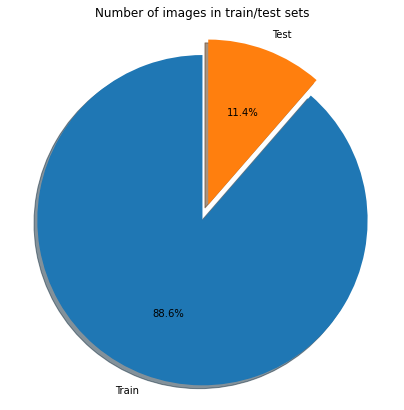

In [6]:
# visualize pie chart
labels = 'Train', 'Test'
sizes = [len(train), len(test)]
explode = (0, 0.1)  # "explode" the 2nd slice

fig, ax = plt.subplots(figsize=(7,7))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Number of images in train/test sets")
plt.show()


Pie chart showing the number of training and test images in our dataset. There are 88.6% in training set and 11.4% in test set.

**Exploring the number of examples with Pneumothorax in train set**

In [7]:
without_pneumothorax = train_rle[train_rle[' EncodedPixels'] == ' -1'][' EncodedPixels'].count() # note that the name of the column starts with a space 0_o
with_pneumothorax = train_rle[train_rle[' EncodedPixels'] != ' -1'][' EncodedPixels'].count()

print('There are {} samples with pneumothorax in training set.'.format(with_pneumothorax))
print('There are {} samples without pneumothorax in training set.'.format(without_pneumothorax))

There are 3286 samples with pneumothorax in training set.
There are 8296 samples without pneumothorax in training set.


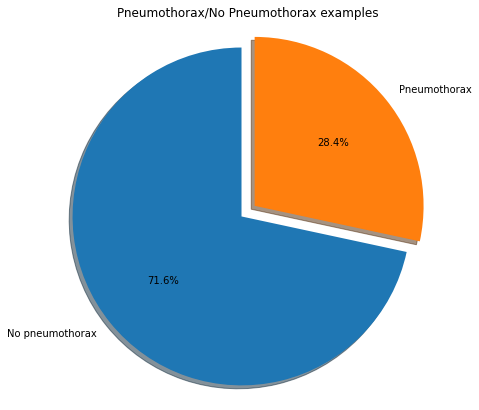

In [8]:
# visualize pie chart
labels = 'No pneumothorax', 'Pneumothorax'
sizes = [without_pneumothorax, with_pneumothorax]
explode = (0, 0.1)  # "explode" the 2nd slice

fig, ax = plt.subplots(figsize=(7,7))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Pneumothorax/No Pneumothorax examples")
plt.show()

It can be seen that the training set is not balanced: most images have no pneumothorax.

In [9]:
missing = len(train_rle) - len(train)
print('There are {} missing samples.'.format(missing))

There are 870 missing samples.


**Exploring the train data**

In [10]:
#dataframe to ease the access
patients = []
missing = 0

pd.reset_option('max_colwidth')

for t in train:
    data = pydicom.dcmread(t)
    patient = {}
    patient["UID"] = data.SOPInstanceUID
    try:
        encoded_pixels = train_rle[train_rle["ImageId"] == patient["UID"]].values[0][1]
        patient["EncodedPixels"] = encoded_pixels
    except:
        missing = missing + 1
    patient["Age"] = data.PatientAge
    patient["Sex"] = data.PatientSex
    patient["Modality"] = data.Modality
    patient["BodyPart"] = data.BodyPartExamined
    patient["ViewPosition"] = data.ViewPosition
    patient["path"] = "../input/siim-acr-pneumothorax-segmentation-data/dicom-images-train/" + data.StudyInstanceUID + "/" + data.SeriesInstanceUID + "/" + data.SOPInstanceUID + ".dcm"
    patients.append(patient)

print("missing labels: ", missing)
#pd.set_option('display.max_colwidth', -1)
df_patients = pd.DataFrame(patients, columns=["UID", "EncodedPixels", "Age", "Sex", "Modality", "BodyPart", "ViewPosition", "path"])
print("images with labels: ", df_patients.shape[0])
df_patients.head()

missing labels:  37
images with labels:  10712


,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38,M,CR,CHEST,PA,../input/siim-acr-pneumothorax-segmentation-da...
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10,F,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50,F,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68,F,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65,M,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...


However, we now have a data frame that makes it easy to view certain aspects of train metadata. Let us first consider the gender and the diagnostic distributions.

In [11]:
#gender
men = df_patients[df_patients["Sex"] == "M"].shape[0]
women = df_patients.shape[0] - men
print(men, women)

5903 4809


In [12]:
#illness
healthy = df_patients[df_patients["EncodedPixels"] == " -1"].shape[0]
ill = df_patients.shape[0] - healthy
print(healthy, ill)

8296 2416


In [13]:
#gender + illness
men_healthy = df_patients[(df_patients["Sex"] == "M") & (df_patients["EncodedPixels"] == " -1")].shape[0]
men_illness = men - men_healthy
women_healthy = df_patients[(df_patients["Sex"] == "F") & (df_patients["EncodedPixels"] == " -1")].shape[0]
women_illness = women - women_healthy
print(men_healthy, men_illness, women_healthy, women_illness)

4554 1349 3742 1067


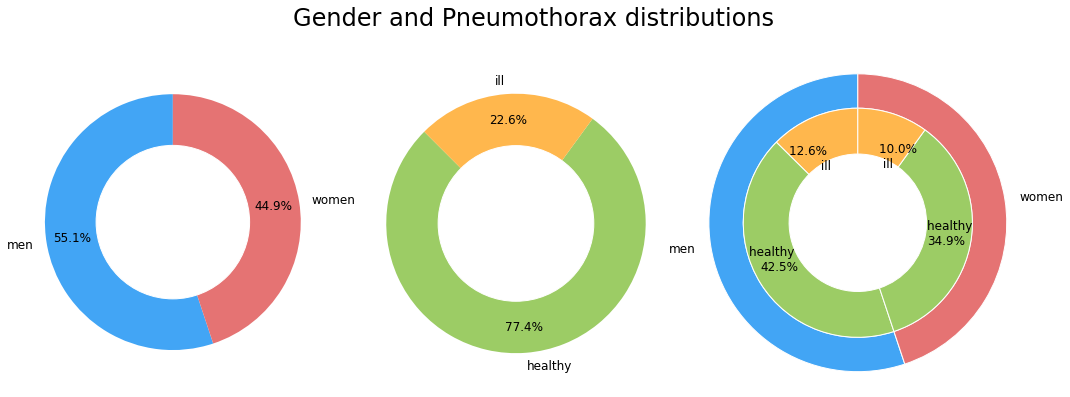

In [17]:
# https://matplotlib.org/3.2.2/gallery/pie_and_polar_charts/pie_and_donut_labels.html?highlight=donut%20chart#references
# https://stackoverflow.com/questions/44153457/double-donut-chart-in-matplotlib
import matplotlib as mpl
import numpy as np
percentage = [str(round(men_illness/107.12, 1)) + "% \n ill", "healthy \n" + str(round(men_healthy/107.12, 1)) + "%", "healthy \n" + str(round(women_healthy/107.12, 1)) + "%",str(round(women_illness/107.12, 1)) + "% \n ill"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Gender and Pneumothorax distributions", fontsize=24, y=1.1)

mpl.rcParams['font.size'] = 12.0

#circle for donut chart
circle0 = plt.Circle( (0,0), 0.6, color = 'white')
circle1 = plt.Circle( (0,0), 0.4, color = 'white')
circle2 = plt.Circle( (0,0), 0.6, color = 'white')

#men women
ax[0].pie([men, women], labels=["men", "women"], colors=["#42A5F5", "#E57373"], autopct='%1.1f%%', pctdistance=0.8, startangle=90)
ax[0].add_patch(circle0)
ax[0].axis('equal')

#gender healthy
mypie, _ = ax[2].pie([men, women], radius=1.3, labels=["men", "women"], colors=["#42A5F5", "#E57373"], startangle=90)
plt.setp( mypie, width=0.3, edgecolor='white')

mypie2, _ = ax[2].pie([ men_illness, men_healthy, women_healthy, women_illness], radius = 1.3 - 0.3, labels=percentage, labeldistance=0.61,
                      colors = ["#FFB74D", "#9CCC65", "#9CCC65", "#FFB74D"], startangle=90)
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

#healthy ill
ax[1].pie([healthy, ill], labels=["healthy", "ill"], colors=["#9CCC65", "#FFB74D"], autopct='%1.1f%%', pctdistance=0.8, startangle=135)
ax[1].add_patch(circle2)
ax[1].axis('equal')  

plt.tight_layout()
plt.show()

There are slightly more men with pneumothorax than women. We also know the age of the patients, so let's look at the age distribution. To create a histogram, you need to know the maximum age, e.g. by sorting.
in the second pie chart, we found healthy percentage is more that illness in men and women that is around 77.4% healthy and 22.6% illness.

In [18]:
print(df_patients.isnull())

         UID  EncodedPixels    Age    Sex  Modality  BodyPart  ViewPosition  \
0      False          False  False  False     False     False         False   
1      False          False  False  False     False     False         False   
2      False          False  False  False     False     False         False   
3      False          False  False  False     False     False         False   
4      False          False  False  False     False     False         False   
...      ...            ...    ...    ...       ...       ...           ...   
10707  False          False  False  False     False     False         False   
10708  False          False  False  False     False     False         False   
10709  False          False  False  False     False     False         False   
10710  False          False  False  False     False     False         False   
10711  False          False  False  False     False     False         False   

        path  
0      False  
1      False  
2     

In [19]:
print(df_patients.isnull().sum())

UID               0
EncodedPixels    37
Age               0
Sex               0
Modality          0
BodyPart          0
ViewPosition      0
path              0
dtype: int64


In [ ]:
# save csv for later
# train_rle_meta_cleaned.to_csv('train_data_meta.csv')

In [20]:
train_rle_meta_cleaned = df_patients.dropna()

In [21]:
#convert the Age column to int
train_rle_meta_cleaned["Age"] = pd.to_numeric(train_rle_meta_cleaned["Age"])

sorted_ages = np.sort(train_rle_meta_cleaned["Age"].values)
print(sorted_ages)

[  1   2   2 ...  94 148 413]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Wow, there seem to be errors in the record, 413 is very old and 148 is amazing too. For the histogram, I will remove these two values.

We seem to have outliers for age values. Let's look at the lines where the age is over 100 years:

In [22]:
train_rle_meta_cleaned[train_rle_meta_cleaned['Age'] > 100]

,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,path
1210,1.2.276.0.7230010.3.1.4.8323329.11106.15178752...,-1,413,F,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...
9656,1.2.276.0.7230010.3.1.4.8323329.4830.151787518...,-1,148,M,CR,CHEST,PA,../input/siim-acr-pneumothorax-segmentation-da...


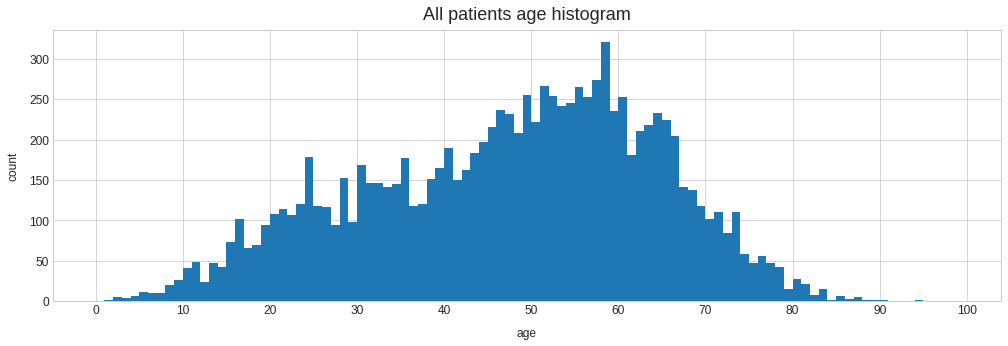

In [23]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(17, 5))
plt.hist(sorted_ages[:-2], bins=[i for i in range(100)])
plt.title("All patients age histogram", fontsize=18, pad=10)
plt.xlabel("age", labelpad=10)
plt.xticks([i*10 for i in range(11)])
plt.ylabel("count", labelpad=10)
plt.show()


From this histogram, we can easily count age of patient on the basis of their count. for the age of 60, there are more number of counts and patients age in between 47 to 66 having more than 200 count.  

Text(0.5, 1.0, 'Age with Pneumothorax')

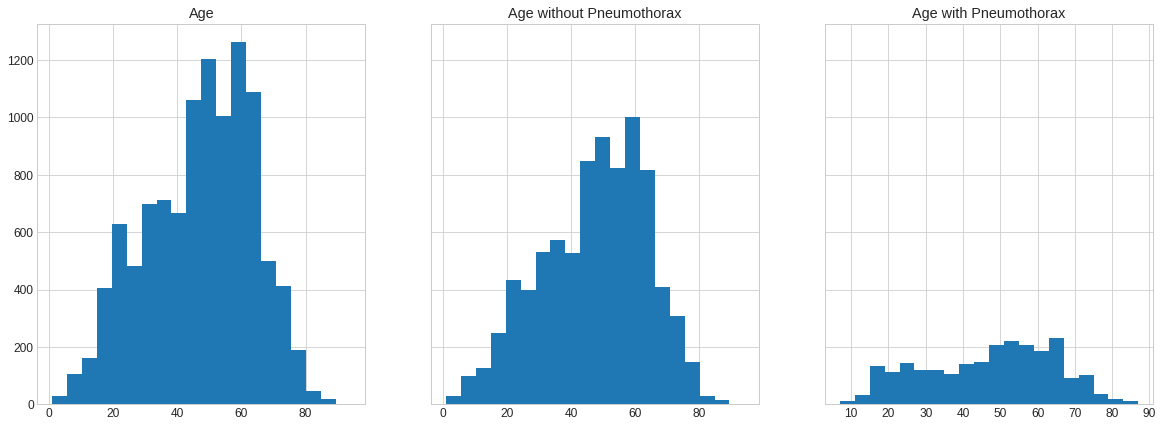

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20,7), sharey=True,)

axs[0].hist(train_rle_meta_cleaned[train_rle_meta_cleaned['Age'] < 100]['Age'].values, bins=20)
axs[0].set_title('Age')

axs[1].hist(train_rle_meta_cleaned[(train_rle_meta_cleaned['Age'] < 100) & (train_rle_meta_cleaned['EncodedPixels'] == ' -1')]['Age'].values, bins=20)
axs[1].set_title('Age without Pneumothorax')

axs[2].hist(train_rle_meta_cleaned[(train_rle_meta_cleaned['Age'] < 100) & (train_rle_meta_cleaned['EncodedPixels'] != ' -1')]['Age'].values, bins=20)
axs[2].set_title('Age with Pneumothorax')

It seems that Pneumothorax doesn't really depend on one's age.

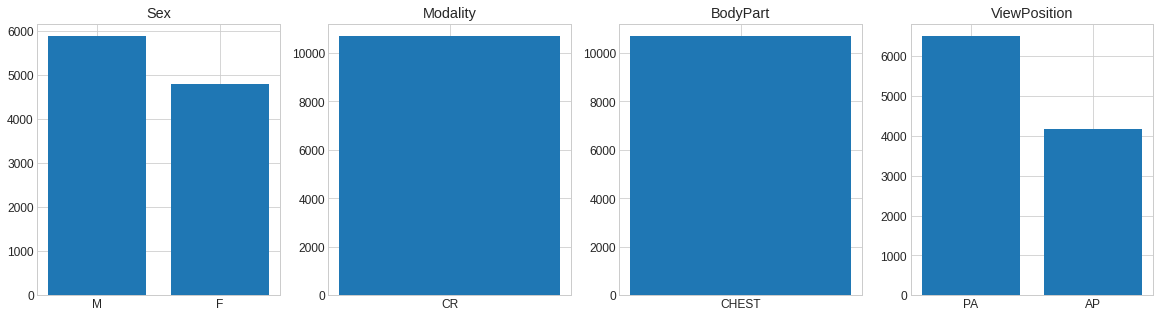

In [25]:
columns = ['Sex', 'Modality', 'BodyPart', 'ViewPosition']

fig, axs = plt.subplots(1, 4, figsize=(20,5))

for i in range(4):
    column = columns[i]
    
    x_pos = np.arange(0, len(train_rle_meta_cleaned[column].unique()))
    
    axs[i].bar(x_pos, train_rle_meta_cleaned[column].value_counts().values, align='center')
    
    tick_labels = []
    for label in train_rle_meta_cleaned[column].value_counts().index.values.tolist():
        tick_labels.append(label)
        
    axs[i].set_xticks(range(len(tick_labels)))
    axs[i].set_xticklabels(tick_labels)

    axs[i].set_title(column)

The modality and properties of the body part are not meaningful. It's pretty obvious that we all have the same type of pictures.

Next let's check the other extracted attributes: Modality, BodyPart, ViewPosition.

In [26]:
bodypart = train_rle_meta_cleaned["BodyPart"].values
print("Body parts:", list(set(bodypart)))

modality = train_rle_meta_cleaned["Modality"].values
print("Modality:", list(set(modality)))

view = list(train_rle_meta_cleaned["ViewPosition"].values)
print("View Positions: ", list(set(view)))

pa = view.count("PA")
ap = view.count("AP")
print(pa, ap)

Body parts: ['CHEST']
Modality: ['CR']
View Positions:  ['PA', 'AP']
6494 4181


The importance of view positions on an x-ray image
The view position can be AP or PA. These refer to the way of x-ray in the body, based on this source

https://www.quora.com/What-is-the-difference-between-an-AP-and-a-PA-view-of-an-X-ray

PA: passes from posterior of the body to anterior --> getting better anterior shadings

AP: passes from anterior of the body to posterior --> getting better posterior shaginds

They say usually AP view is used for x-rays, but in the case of the chest x-rays are rather taken from the PA view. If the health level of the patient does not allow to do PA, AP can also help. It would be interesting to check the Pneumothorax severity level in relation to view position too. But first, we have to decode the run-length-encoding (RLE) present int the train csv file.

# What is DICOM?
 
Dicom is a format that has metadata, as well as Pixeldata attached to it. Below I extract some basic info with an image. You will know about the gender and age of the patient, as well as info how the image is sampled and generated. Quite useful to programatically read. Here's the Wikipedia article for it.

# Visualizing The Chest X-Ray

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

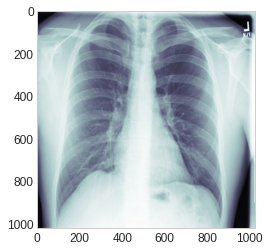

In [32]:
import pydicom
import matplotlib.pyplot as plt

#displaying the image
img = pydicom.read_file(train[0]).pixel_array
plt.imshow(img, cmap='bone')
plt.grid(False)

#displaying metadata
data = pydicom.dcmread(train[0])
print(data)

The run-length-encoding(RLE):

So as we could see, the train csv contains the image id and the rle-encodings of the place of Pneumothorax. But what does this mean? Run-length-encoding (RLE) is a simple lossless compression method, it replaces data sequences with identical values (run) with the respective value stored once and . It can be useful when the data contains relatively long sequences. Here is a very simple example.
As we could see, the train's CSV contains the image identification and the rle encodes of the location of the pneumothorax. But what does that mean? Run Length Coding (RLE) is a simple lossless compression method in which data streams are replaced by identical values (run) by the value stored once and the length of the run. This can be useful if the data contains relatively long sequences. Here is a very simple example.

In [46]:
def get_metadata(file_path):
    '''
    Function get the metadata from file.
    INPUT:
        file_path - path to the file containing the image
    OUTPUT:
        age - patient's age
        sex - patient's sex
        modality - represents file type (CR = Computed Radiography) (see https://www.dicomlibrary.com/dicom/modality/)
        body_part - part of the body on image
        view_position - PA or AP (PA - view from posterior, AP - the opposite view,
            see https://www.quora.com/What-is-the-difference-between-an-AP-and-a-PA-view-of-an-X-ray)
    '''
    
    data = pydicom.dcmread(file_path)
    
    age = data.PatientAge
    sex = data.PatientSex
    modality = data.Modality
    body_part = data.BodyPartExamined
    view_position = data.ViewPosition

    return age, sex, modality, body_part, view_position

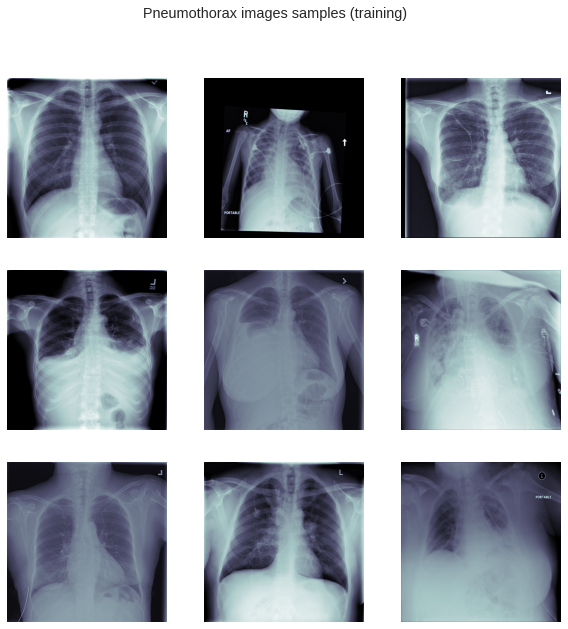

In [34]:
# Plot 9 random images from training dataset
fig, axs = plt.subplots(3, 3, figsize=(10,10))
    
for im in range(9):
    i = im // 3
    j = im % 3

    # choose random images from train set
    fn = np.random.choice(train)
    img = pydicom.read_file(fn).pixel_array

    #plot the data
    axs[i,j].imshow(img, cmap='bone')
    axs[i,j].axis('off')
        
# set suptitle
plt.suptitle('Pneumothorax images samples (training)')
plt.show()

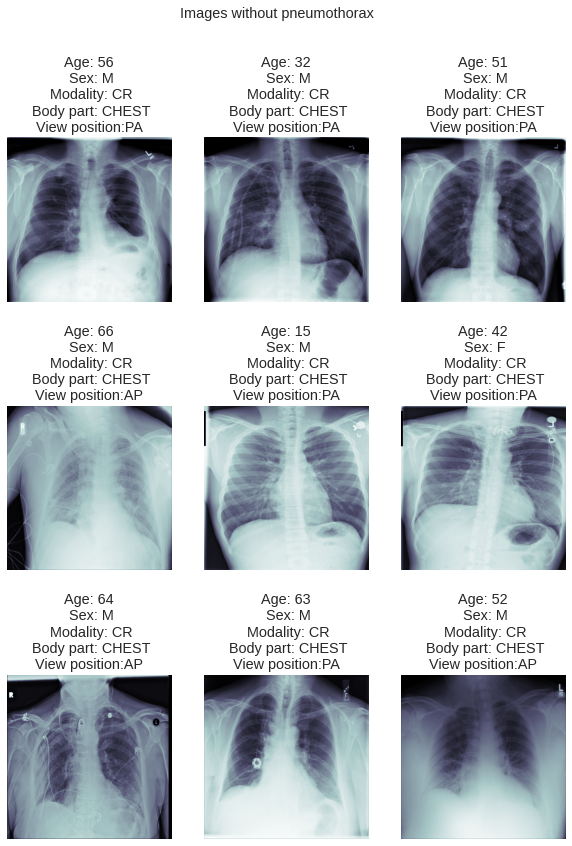

In [47]:
fig, axs = plt.subplots(3, 3, figsize=(10,14))
im = 0

while im < 9:
    i = im // 3
    j = im % 3

    # get random images from training set
    fn = np.random.choice(train)
    img = pydicom.read_file(fn).pixel_array
    
    # get id of the image
    image_id = fn.split('/')[-1][:-4]
    
    # find mask
    # if mask = -1 (no Pneumothorax) then display image and increase counter
    # otherwise look for another image
    mask = train_rle[train_rle.ImageId == image_id].iloc[0].values[1]
    if mask == ' -1':
        im += 1
        meta = get_metadata(fn)
        axs[i,j].imshow(img, cmap='bone') #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title('Age: {age}\n Sex: {sex}\n Modality: {modality}\n Body part: {body_part}\n View position:{view} '.format(age = meta[0],
                                                                                                                                   sex = meta[1],
                                                                                                                                   modality = meta[2],
                                                                                                                                   body_part = meta[3],
                                                                                                                                   view = meta[4]))
        
# set suptitle
plt.suptitle('Images without pneumothorax')
plt.show()

It seems that we can easily distinguish male from female adults looking on these images.

Now it is time to visualize images, which contain Pneumothorax and will plot both the original image and the image with mask

In [48]:
#mask functions from sample dataset
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,20))
im = 0

while im < 3:
    i = im

    # get random images from training set
    fn = np.random.choice(train)
    img = pydicom.read_file(fn).pixel_array
    
    # get id of the image
    image_id = fn.split('/')[-1][:-4]
    
    # find mask
    # if mask is not -1 (no Pneumothorax) then display image and increase counter
    # otherwise look for another image
    mask = train_rle[train_rle.ImageId == image_id].iloc[0].values[1]
    if mask != ' -1':
        im += 1
        
        #plot the original data
        axs[i,0].imshow(img, cmap='bone') 
        axs[i,0].axis('off')
        meta = get_metadata(fn)
        # add metadata
        axs[i,0].set_title('Without mask\n Age: {age}\n Sex: {sex}\n Modality: {modality}\n Body part: {body_part}\n View position:{view} '.format(age = meta[0],
                                                                                                                                   sex = meta[1],
                                                                                                                                   modality = meta[2],
                                                                                                                                   body_part = meta[3],
                                                                                                                                   view = meta[4]))
        
        #plot data and add the mask
        axs[i,1].imshow(img, cmap='bone')
        axs[i,1].axis('off')  
        rle_mask = rle2mask(mask, 1024, 1024).T
        axs[i,1].imshow(rle_mask, alpha=0.3, cmap="Reds")    
        axs[i,1].set_title('With mask')
        
# set suptitle
plt.suptitle('Images with pneumothorax')
plt.show()